In [45]:
from __future__ import print_function, division

import numpy as np
from keras.utils import plot_model
from keras.layers import *
from keras.models import Sequential, Model
from keras import optimizers

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

__date__ = '2018-10-25'

In [46]:
def create_dcnn_model(window_size, kernel_size=2, n_filters=4, n_input_series=1, n_outputs=1):
#     model = Sequential((
#         # The first conv layer learns `n_filters` filters (aka kernels), each of size ``(kernel_size, n_input_series)``.
#         # Its output will have shape (None, window_size - kernel_size + 1, n_filters), i.e., for each position in
#         # the input timeseries, the activation of each filter at that position.
#         Conv1D(n_filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(window_size, n_input_series)),
#         MaxPooling1D(),     # Downsample the output of convolution by 2X.
#         Convolution1D(n_filters=n_filters, kernel_size=kernel_size, activation='relu'),
#         MaxPooling1D(),
#         Flatten(),
#         Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
#     ))
    input_layer = Input(shape=(window_size, n_input_series), name='input_1')
    c1_layer = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=1, 
                      padding='causal', activation='relu', name='conv1d_1')(input_layer)
    c2_layer = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=2, 
                      padding='causal', activation='relu', name='conv1d_2')(c1_layer)
    c3_layer = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=4, 
                      padding='causal', activation='relu', name='conv1d_3')(c2_layer)
    c4_layer = concatenate([c1_layer, c3_layer])
    #conv_out = Conv1D(8, 1, activation='relu')(c3_layer)
    output = Flatten()(c4_layer)
    output = Dense(n_outputs, activation='linear')(output)
    model = Model(inputs=input_layer, outputs=output)
    adam = optimizers.Adam(lr=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['mae'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model


In [42]:
model = create_dcnn_model(window_size=10)
model.summary()
plot_model(model, to_file='dilated_cnn.png') # Run 'pip install pydot' before plotting if this package is missing

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 4)        12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 10, 4)        36          conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 10, 4)        36          conv1d_2[0][0]                   
__________________________________________________________________________________________________
concatenat

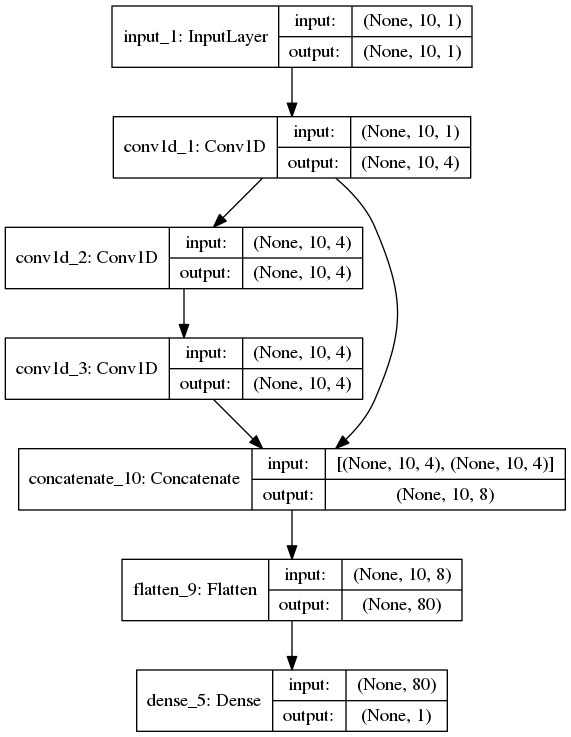

In [43]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

Image(model_to_dot(model, show_shapes=True).create(prog='dot', format='png'))

In [39]:
def make_timeseries_instances(timeseries, window_size):
    """Make input features and prediction targets from a `timeseries` for use in machine learning.

    :return: A tuple of `(X, y, q)`.  `X` are the inputs to a predictor, a 3D ndarray with shape
      ``(timeseries.shape[0] - window_size, window_size, timeseries.shape[1] or 1)``.  For each row of `X`, the
      corresponding row of `y` is the next value in the timeseries.  The `q` or query is the last instance, what you would use
      to predict a hypothetical next (unprovided) value in the `timeseries`.
    :param ndarray timeseries: Either a simple vector, or a matrix of shape ``(timestep, series_num)``, i.e., time is axis 0 (the
      row) and the series is axis 1 (the column).
    :param int window_size: The number of samples to use as input prediction features (also called the lag or lookback).
    """
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

In [37]:
def evaluate_timeseries(timeseries, window_size):
    """Create a 1D CNN regressor to predict the next value in a `timeseries` using the preceding `window_size` elements
    as input features and evaluate its performance.

    :param ndarray timeseries: Timeseries data with time increasing down the rows (the leading dimension/axis).
    :param int window_size: The number of previous timeseries values to use to predict the next.
    """
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    print('\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries)
    model = create_dcnn_model(window_size=window_size, kernel_size=filter_length, n_input_series=nb_series, n_outputs=nb_series, n_filters=nb_filter)
    print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length))
    model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    print('\n\nInput features:', X, '\n\nOutput labels:', y, '\n\nQuery vector:', q, sep='\n')
    test_size = int(0.01 * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

    pred = model.predict(X_test)
    print('\n\nactual', 'predicted', sep='\t')
    for actual, predicted in zip(y_test, pred.squeeze()):
        print(actual.squeeze(), predicted, sep='\t')
    print('next', model.predict(q).squeeze(), sep='\t')


In [47]:
def main():
    """Prepare input data, build model, evaluate."""
    np.set_printoptions(threshold=25)
    ts_length = 1000
    window_size = 50

    print('\nSimple single timeseries vector prediction')
    timeseries = np.arange(ts_length)                   # The timeseries f(t) = t
    evaluate_timeseries(timeseries, window_size)

    print('\nMultiple-input, multiple-output prediction')
    timeseries = np.array([np.arange(ts_length), -np.arange(ts_length)]).T      # The timeseries f(t) = [t, -t]
    evaluate_timeseries(timeseries, window_size)


if __name__ == '__main__':
    main()


Simple single timeseries vector prediction


Timeseries (1000 samples by 1 series):
 [[  0]
 [  1]
 [  2]
 ...
 [997]
 [998]
 [999]]


Model with input size (None, 50, 1), output size (None, 1), 4 conv filters of length 5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 4)        24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 4)        84          conv1d_1[0][0]                   
____________________________________________________________________________________

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 940 samples, validate on 10 samples
Epoch 1/25
940/940 [==============================] - 1s 2ms/step - loss: 2857.7504 - mean_absolute_error: 25.0098 - val_loss: 1.2942 - val_mean_absolute_error: 1.1353
Epoch 2/25
940/940 [==============================] - 1s 1ms/step - loss: 581.0652 - mean_absolute_error: 18.1277 - val_loss: 0.1533 - val_mean_absolute_error: 0.3873
Epoch 3/25
940/940 [==============================] - 1s 1ms/step - loss: 172.6792 - mean_absolute_error: 9.1360 - val_loss: 229.2880 - val_mean_absolute_error: 15.1421
Epoch 4/25
940/940 [==============================] - 1s 1ms/step - loss: 17.2856 - mean_absolute_error: 2.1549 - val_loss: 0.2039 - val_mean_absolute_error: 0.4516
Epoch 5/25
940/940 [==============================] - 1s 1ms/step - loss: 0.0845 - mean_absolute_error: 0.1818 - val_loss: 23.0162 - val_mean_absolute_error: 4.7975
Epoch 6/25
940/940 [==============================] - 1s 1ms/step - loss: 1272.4199 - mean_absolute_error: 12.3838 - val_

940/940 [==============================] - 1s 1ms/step - loss: 177.9678 - mean_absolute_error: 7.0271 - val_loss: 30.9993 - val_mean_absolute_error: 4.5617
Epoch 6/25
940/940 [==============================] - 1s 1ms/step - loss: 2673.1432 - mean_absolute_error: 20.3588 - val_loss: 0.2616 - val_mean_absolute_error: 0.5114
Epoch 7/25
940/940 [==============================] - 1s 1ms/step - loss: 6080.0359 - mean_absolute_error: 20.8604 - val_loss: 276652.5000 - val_mean_absolute_error: 525.9745
Epoch 8/25
940/940 [==============================] - 1s 1ms/step - loss: 1709.8570 - mean_absolute_error: 18.6420 - val_loss: 0.0459 - val_mean_absolute_error: 0.2117
Epoch 9/25
940/940 [==============================] - 1s 1ms/step - loss: 0.5067 - mean_absolute_error: 0.2883 - val_loss: 6.8975e-05 - val_mean_absolute_error: 0.0083
Epoch 10/25
940/940 [==============================] - 1s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0291 - val_loss: 0.0022 - val_mean_absolute_error: 0.0472
